In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import trackpy as tp
import pims
import matplotlib as mpl
import scipy.linalg as linalg

In [2]:

def calculateNoise(I):
    '''
    #regular inline code      threshold = noisecalculator(I);
    #regular function code    function [ threshold ] = noisecalculator( I )
    # now comes the noisecalculator
    # This function calculates the amount of noise in an image. The returned
    # value 'noiseI' is the noise intensity which should be removed from all
    # images in a .tif file.
    # It's probably sufficient to run this function once for every .tif file,
    # since approximately all images in the file contain the same amount of
    # noise. This will reduce the calculation time drastically. '''
        
    # Delete background intensity
    In = I.flatten()           # Most Python functions don't work for a 2D array, so In has to be flattened.
    Im = np.sort(In)            # A sorted list of I, with background intensity. 
    plt.figure()
    plt.title('Sorted intensity values')
    plt.xlabel('x')   
    plt.ylabel('y')   
    plt.grid()
    plt.plot(Im)                # In this plot it can be seen that Im has been correctly sorted. 
    med = np.median(Im)         # The median of IM can be calculated from the flattened sorted array Im.       
    Imed = abs(I - med)


    # Calculate the noise intensity
    ilst = np.sort(Imed)                    # To create a sorted list of all present intensities.
    ilstflat = np.sort(ilst.flatten())      # ilst has to be flattened to find the max value with Python.
    ilst_t = ilst.transpose()       
    ilstflat_t = np.sort(ilst_t.flatten())  # With the normal flatten function the rows are put bewelow eacht other, but we want to put the columns next to each other. Thus the transposed version of ilst is needed.
    b = len(Im)
    x = np.arange(1,b+1)
    Ihalf = (max(In)-med)/2
    # Ihalf=max(ilstflat)/2

    # Make sure that the flattened ilst is also sorted, otherwise the wrong index is found.
    xIhalf_value = list(filter(lambda i: i > Ihalf, ilstflat_t))[0]         # This function gives the first value where ilst > Ihalf. With this value it can be checked if the position calculated in the next line is correct.
    xIhalf = next(x for x, val in enumerate(ilstflat_t)
                                      if val > Ihalf)                           # Here the position of the first index with a value bigger than Ihalf is found.
    range_up=int(np.floor(b/2))
    coeff1= np.polyfit(x[0:range_up], ilstflat_t[0:range_up],1)      
    coeff2 = np.polyfit(x[int(xIhalf):b], ilstflat_t[int(xIhalf):b], 1)     # Makes a linear fit to the highest half of all intensities in 'ilist'. 
    if show:
        plt.figure()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Noise intensity')
        plt.grid()
        plt.plot(x,np.sort(ilstflat_t),'b-')    

    # The rightmost intersection is the chosen noise intensity which will be removed from all images.
    fit1 = np.polyval(coeff1,x)                                     # Returns an array of all values of the fitted line for every x coordinate.
    fit2 = np.polyval(coeff2,x)                                         
    xcross=round((coeff1[1]-coeff2[1])/(coeff2[0]-coeff1[0]))
    ycross= np.polyval(coeff1,xcross)
    fit=np.concatenate([fit1[0:int(xcross-1)],fit2[int(xcross-1):]])
    if show:
        plt.plot(x,np.sort(ilstflat_t),'b-', x,fit,'r'), plt.ylim([0,max(ilstflat)])
    scale=max(x)/max(ilstflat)
    dist=np.sqrt((x-xcross)**2+(ycross-ilstflat_t*scale)**2)        # Calculates the difference between the true intensities and the values of crossing fitted lines.
    xmindist = next(x for x, val in enumerate(dist) 
                                  if val == min(dist))              # Calculates the x value of the rightmost intersection of the fitted line and the curve of all true intensities.
    threshold=ilstflat_t[(xmindist-1)]+np.std(ilst)                 # Calculates the intensity, which belongs to the above calculated x value. This equals the intensity of the noise which should be delete.
    if show:
        plt.plot(x,np.sort(ilstflat_t),'b-', x,fit,'k', xcross,ycross,'kx', xmindist, ilstflat_t[xmindist],'mo', [0,max(x)],[threshold,threshold],'r')     
    return threshold

Frame 999: 1 features


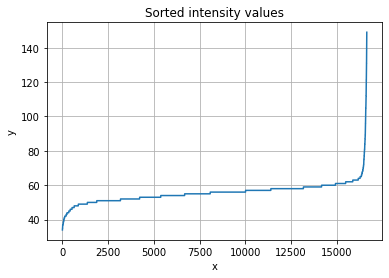

In [6]:
k_b = 1.38*1e-23
T = 293
l_pixel = 4.68*1e-8
show = 0

fileloc = r"trap 20 mW_0.tif"    # File location
frames = pims.open(fileloc)     # import file
threshold = calculateNoise(frames[0])   # Calculate noise threshold of first frame
f = tp.batch(frames,15, minmass = 100, maxsize=10, threshold=threshold, topn=1)    # Find bead location for all frames
X = f['x']
Y = f['y']


In [20]:
sample = 150  # Hertz
k_b = 1.38*1e-23
T = 293
l_pixel = 4.68*1e-8
yg = 6*np.pi*10**(-3)* 10**(-6)   # Drag coefficient   
D = k_b*T/yg   # Diffusion coefficient

from scipy.optimize import curve_fit

    
def k_trap(x):  
    pos = x*l_pixel
    
    '''
    Calculate the trap constant using the x or y position in pixels as input.
    First calculates trap constant when there would be no forces interacting with particle besides laser beam. 
    Then uses power spectrum to calculate actual trap constant.  '''
       # replace nans by average
    pos_ = np.where(np.isnan(pos), np.nanmean(pos), pos)
    
       # Calculate variance 
    var = np.sum((pos_- np.mean(pos_))**2)/(len(pos_)+1)
    
    k_trap = k_b*T/(var)*1e3    # trap constant not taking into account movement of optical trap and change of temperature 

    
#     fsq = (k_trap*1e-3/(2*np.pi*yg))**2 
#     ydata = abs(np.fft.fftshift(np.fft.fft(pos_)))   # Input position of center
#     N = len(ydata) 
#     xdata = np.linspace(-sample/2,sample/2,N+1)[:-1]   # frequency
#     xx = np.where(xdata==0)[0] 
#     ydata[xx] = ydata[xx+1]   # deleting giant peak
#     x_data= xdata[int(xx):]
#     y_data = ydata[int(xx):]
#     csydata = np.cumsum(y_data) 
    
#     def func(x,a,b):
#         f = np.cumsum(a*(x**2+b)**(-1))   #creating function for curve_fit using cumsum
#         return f
    
#     x0 =[D/(np.pi**2),fsq]   # estimate parameters
#     popt, pcov = curve_fit(func,x_data,csydata, p0=x0)   # fitting
#     a,b = popt[0], popt[1]
#     f0 = np.sqrt(b) 
#     k_trap_fit = f0*(2*np.pi*yg)   # fitted k_trap value
    
#     plt.plot(x_data,csydata, linestyle='none', marker='x')
#     plt.plot(x_data,func(x_data,a,b))

    return k_trap

    
def ellipse_calc(x,y):  
        # replace nans by average
    x_ = np.where(np.isnan(x), np.nanmean(x), x)
    y_ = np.where(np.isnan(y), np.nanmean(y), y)
    
       # Calculate variance and covariance
    var_x = np.sum((x_-np.mean(x_))**2)/(len(x)+1)
    var_y = np.sum((y_-np.mean(y_))**2)/(len(y)+1)
    cov = np.sum((x_-np.mean(x_))*(y_-np.mean(y_))/(len(x_)+1))
    
    cov_matrix = np.asarray([[var_x, cov],[cov,var_y]])
    evals,evecs = linalg.eig(cov_matrix)
    evecs_ = evals*evecs
    plt.plot(x,y, linestyle='none',marker='x',zorder=1)
    plt.quiver(np.nanmean(x),np.nanmean(y), -evecs_[1,:],-evecs_[0,:],zorder=2, units='xy', scale=1, width=1e-8, headwidth=4)

    
    a = np.max(evals)
    b = np.min(evals)
    index_a = np.where(evals == a)[0]
    theta = np.arctan(evecs[0,index_a]/evecs[1,index_a])
    plt.show()
    return a,b,theta

#a,b,theta = ellipse_calc(X*l_pixel,Y*l_pixel)
   

def trap_calc(a,b,theta, theta_i):
    ''' Use function to calculate trap constant in arbitrary direction using the covariance ellipse.
    returns trap constant in any arbitrary direction in pN/nm
    a = length of semi-major axis of covariance ellipse
    b = length of semi-minor axis of covariance ellipse
    theta = angle of semi-major with respect to the x-axis in radians
    theta_i = angle of any arbitrary direction with respect to the x-axis in radians  '''
    
    phi = theta_i - theta  # relative angle between major axis and arbitrary direction
    r = a*b/(np.sqrt(b*np.cos(phi))**2 + (a*np.sin(phi))**2)
    k_trap = k_b*T/(r)*1e3   #pN/nM
    return k_trap

# k_x = trap_calc(a,b,theta,0)


k_trap_x = k_trap(X)
print(k_trap_x)


                  

0.003781922031451226


In [ ]:
%matplotlib notebook

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
line, = ax[0].plot(0, 0, marker="1", color="black")
txt = ax[0].text(0,0,'o', color='white')
ani_im = ax[0].imshow(frames[0], origin='lower')

ax[0].set_ylim(0,np.shape(frames)[1])
ax[0].set_xlim(0,np.shape(frames)[2])

linex, = ax[1].plot(0,0, label='y position')
liney, = ax[1].plot(0,0, label='x position')

ax[1].set_xlim(0,np.shape(frames)[0])
ax[1].set_ylim(int(np.min((X,Y))-1), int(np.max((X,Y)))+1)

ax[1].legend()

def animation_frame(iterant):
    ani_im.set_array(frames[iterant])

    #fig.set_title(str(iterant))

    line.set_xdata(X[iterant])
    line.set_ydata(Y[iterant])
#     txt.set_position((Yest[iterant],Xest[iterant]+10))
#     txt.set_text( ( str(Xest[iterant])[0:3],str(Yest[iterant])[0:3] ) )
#     txt.set_color(color[iterant])

    linex.set_xdata(np.arange(iterant))
    liney.set_xdata(np.arange(iterant))
    linex.set_ydata(X[0:iterant])
    liney.set_ydata(Y[0:iterant])
    return [line,linex,liney]

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(np.shape(frames)[0]), interval=10)
plt.show()